# 数据预处理

In [1]:
import torch
import os
import sys
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(r'D:\code\Python-Project\文本数据挖掘\WBClassify')))
from WBClassify.Utils import utils,vocab,Trie
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
import random 
import warnings
warnings.filterwarnings('ignore')
def seed_torch(seed=42):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True

seed_torch()

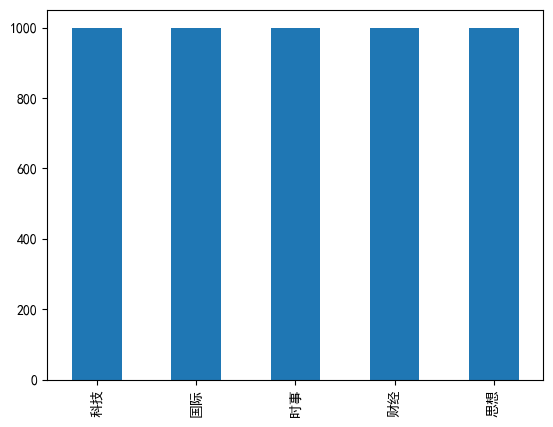

In [2]:
data = pd.read_csv("../Get_Data/train.csv")
data['label'].value_counts().plot(kind='bar')
plt.show()

In [3]:
data

,title,label
0,持续追踪丨俄再度炮击赫尔松，泽连斯基呼吁西方加强乌防空,国际
1,COP15专访｜穿汉服的中国代表团成员讲述谈判背后的故事,国际
2,泰国一艘军舰沉没，搜救队正在寻找33名失踪船员,国际
3,圆桌｜威斯特伐利亚体系从未退场？俄乌冲突下的欧洲之变,国际
4,法国败北马克龙表态：决赛不是提前写好的剧本，希望德尚留任,国际
...,...,...
4995,北京第四批次6宗住宅用地收金135亿元，“热度达到了较高水平”地产界2022-11-29,财经
4996,杭州第四批次供地：8宗宅地收金98.9亿元，其中3宗达到上限价格地产界2022-11-29,财经
4997,独家｜知情人谈张核子和核酸生意：深圳坐拥带停机坪别墅，张姗姗是谁？10%公司2022-11-...,财经
4998,放量大涨沪指收复60日均线，反弹持续性如何？或挑战半年线牛市点线面2022-11-29,财经


In [4]:
# 字符处理
data['title'] = data['title'].map(utils.got_chinese)        # 取出标点符号
data

,title,label
0,持续追踪丨俄再度炮击赫尔松泽连斯基呼吁西方加强乌防空,国际
1,专访穿汉服的中国代表团成员讲述谈判背后的故事,国际
2,泰国一艘军舰沉没搜救队正在寻找名失踪船员,国际
3,圆桌威斯特伐利亚体系从未退场俄乌冲突下的欧洲之变,国际
4,法国败北马克龙表态决赛不是提前写好的剧本希望德尚留任,国际
...,...,...
4995,北京第四批次宗住宅用地收金亿元热度达到了较高水平地产界,财经
4996,杭州第四批次供地宗宅地收金亿元其中宗达到上限价格地产界,财经
4997,独家知情人谈张核子和核酸生意深圳坐拥带停机坪别墅张姗姗是谁公司,财经
4998,放量大涨沪指收复日均线反弹持续性如何或挑战半年线牛市点线面,财经


In [5]:
# 进行分词
cut_words = utils.cut_word(data['title'].to_list(),method='hanlp')  # 分词

In [6]:
# 停用词过滤
stopwords = pd.read_csv("../Get_data/hit_stopwords.txt",index_col=False,sep="\t",quoting=3,names=['stopword'], encoding='utf-8').stopword.values.tolist() #list
stopwords

['丨',
 '｜',
 '｜',
 '———',
 '》），',
 '）÷（１－',
 '”，',
 '）、',
 '＝（',
 ':',
 '→',
 '℃ ',
 '&',
 '*',
 '一一',
 '~~~~',
 '’',
 '. ',
 '『',
 '.一',
 './',
 '-- ',
 '』',
 '＝″',
 '【',
 '［＊］',
 '｝＞',
 '［⑤］］',
 '［①Ｄ］',
 'ｃ］',
 'ｎｇ昉',
 '＊',
 '//',
 '［',
 '］',
 '［②ｅ］',
 '［②ｇ］',
 '＝｛',
 '}',
 '，也 ',
 '‘',
 'Ａ',
 '［①⑥］',
 '［②Ｂ］ ',
 '［①ａ］',
 '［④ａ］',
 '［①③］',
 '［③ｈ］',
 '③］',
 '１． ',
 '－－ ',
 '［②ｂ］',
 '’‘ ',
 '××× ',
 '［①⑧］',
 '０：２ ',
 '＝［',
 '［⑤ｂ］',
 '［②ｃ］ ',
 '［④ｂ］',
 '［②③］',
 '［③ａ］',
 '［④ｃ］',
 '［①⑤］',
 '［①⑦］',
 '［①ｇ］',
 '∈［ ',
 '［①⑨］',
 '［①④］',
 '［①ｃ］',
 '［②ｆ］',
 '［②⑧］',
 '［②①］',
 '［①Ｃ］',
 '［③ｃ］',
 '［③ｇ］',
 '［②⑤］',
 '［②②］',
 '一.',
 '［①ｈ］',
 '.数',
 '［］',
 '［①Ｂ］',
 '数/',
 '［①ｉ］',
 '［③ｅ］',
 '［①①］',
 '［④ｄ］',
 '［④ｅ］',
 '［③ｂ］',
 '［⑤ａ］',
 '［①Ａ］',
 '［②⑧］',
 '［②⑦］',
 '［①ｄ］',
 '［②ｊ］',
 '〕〔',
 '］［',
 '://',
 '′∈',
 '［②④',
 '［⑤ｅ］',
 '１２％',
 'ｂ］',
 '...',
 '...................',
 '…………………………………………………③',
 'ＺＸＦＩＴＬ',
 '［③Ｆ］',
 '」',
 '［①ｏ］',
 '］∧′＝［ ',
 '∪φ∈',
 '′｜',
 '｛－',
 '②ｃ',
 '｝',
 '［③①］',
 'Ｒ．Ｌ．',
 '［①Ｅ］',
 'Ψ',


In [7]:
utils.Dropwords(stopwords,cut_words)

([['持续', '追踪', '俄', '再度', '炮击', '赫尔松泽连斯基', '呼吁', '西方', '加强', '乌', '防空'],
  ['专访', '穿', '汉服', '中国代表团', '成员', '讲述', '谈判', '背后', '故事'],
  ['泰国', '艘', '军舰', '沉没', '搜救队', '正在', '寻找', '名', '失踪', '船员'],
  ['圆桌', '威斯特伐利亚', '体系', '从未', '退场', '俄', '乌', '冲突', '下', '欧洲', '变'],
  ['法国',
   '败',
   '北',
   '马克龙',
   '表态',
   '决赛',
   '不是',
   '提前',
   '写',
   '好',
   '剧本',
   '希望',
   '德尚',
   '留任'],
  ['欧盟', '天然气', '价格', '上限', '协议', '达成', '兆瓦时欧元'],
  ['加拿大', '旺市', '发生', '枪击', '案', '包括', '嫌疑', '人', '在内', '人', '死亡'],
  ['欧盟', '碳', '排放', '交易', '体系', '改革', '达成', '临时', '协议', '加大', '减排', '力度'],
  ['马克龙', '法国队', '更衣室', '内', '讲话', '内容', '曝光', '差一点', '赢'],
  ['驻', '英', '使馆', '英议会下院外委会', '报告', '涉', '华', '内容', '歪曲', '事实', '误导', '公众'],
  ['中国代表团', '成员', '高翔', '穿', '汉服', '谈判'],
  ['调查', '远程', '办公', '日本', '民众', '睡眠', '娱乐', '时间', '增多'],
  ['日本', '塞内加尔', '石油', '天然气', '开发', '合作', '达成', '一致'],
  ['昆明', '蒙特利尔', '全球', '生物', '多样性', '框架'],
  ['韩国文体部', '不', '两成', '受', '访', '韩国', '民众', '认为', '结婚', '人生', '必', '选', '项'],
  

In [8]:
# 放入词典
vocab = vocab.Vocab(cut_words,reserved_tokens=['<pad>'])
vocab

In [9]:
vocab[cut_words[0]]

[213, 770, 25, 44, 1745, 5955, 5956, 533, 709, 335, 109, 1746]

<AxesSubplot:ylabel='Count'>

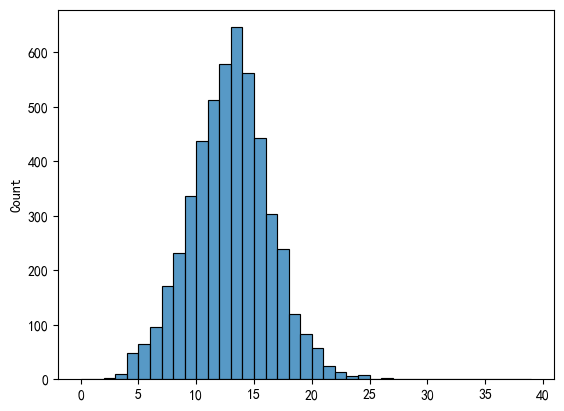

In [10]:
# 每句话的长度
import seaborn as sns
sns.histplot([len(vocab[i]) for i in cut_words],bins=range(0, 40, 1))

从这里可以看出有些句子很短，大部分句子长度集中在5-20之间。

In [11]:
def truncate_pad(line, num_steps, padding_token):
    """截取或者填充句子 @ utils

    Args:
        line (array): 一个句子
        num_steps (int): 时间步数，也就是我们所说的长度
        padding_token (str): 填充的token（词元）

    Returns:
        list: list
    """
    if len(line) > num_steps:
        return line[:num_steps]  # 截取
    return line + [padding_token] * (num_steps - len(line))  # 填充

In [12]:
cut_words = [utils.truncate_pad(i,20,"<pad>") for i in cut_words]
cut_words

[['持续',
  '追踪',
  '丨',
  '俄',
  '再度',
  '炮击',
  '赫尔松泽连斯基',
  '呼吁',
  '西方',
  '加强',
  '乌',
  '防空',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['专访',
  '穿',
  '汉服',
  '的',
  '中国代表团',
  '成员',
  '讲述',
  '谈判',
  '背后',
  '的',
  '故事',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['泰国',
  '一',
  '艘',
  '军舰',
  '沉没',
  '搜救队',
  '正在',
  '寻找',
  '名',
  '失踪',
  '船员',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['圆桌',
  '威斯特伐利亚',
  '体系',
  '从未',
  '退场',
  '俄',
  '乌',
  '冲突',
  '下',
  '的',
  '欧洲',
  '之',
  '变',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['法国',
  '败',
  '北',
  '马克龙',
  '表态',
  '决赛',
  '不是',
  '提前',
  '写',
  '好',
  '的',
  '剧本',
  '希望',
  '德尚',
  '留任',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['欧盟',
  '天然气',
  '价格',
  '上限',
  '协议',
  '达成',
  '每',
  '兆瓦时欧元',
  '<pad>',
  '<pad>'

In [13]:
data_ = [utils.truncate_pad(vocab[i],20,vocab['<pad>']) for i in cut_words]
data_

[[213,
  770,
  25,
  44,
  1745,
  5955,
  5956,
  533,
  709,
  335,
  109,
  1746,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [244,
  1747,
  4017,
  2,
  3036,
  1190,
  1191,
  534,
  263,
  2,
  407,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1748,
  16,
  2436,
  3037,
  3038,
  5957,
  710,
  1518,
  172,
  1749,
  5958,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [502,
  5959,
  711,
  1519,
  4018,
  44,
  109,
  408,
  74,
  2,
  432,
  37,
  657,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [296,
  4019,
  1192,
  474,
  980,
  1078,
  614,
  1079,
  902,
  98,
  2,
  5960,
  615,
  5961,
  5962,
  1,
  1,
  1,
  1,
  1],
 [214,
  1520,
  312,
  1193,
  535,
  771,
  772,
  5963,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [773,
  5964,
  271,
  1332,
  223,
  1080,
  2437,
  24,
  4020,
  24,
  264,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [214,
  80,
  536,
  1521,
  616,
  711,
  712,
  771,
  1333,
  535,
  1334,
  5965,
  1522,
  1,
  1,
  1,
  1

In [14]:
# 小批量加载
class Dataset(Dataset):             # pytorch对数据的封装，重写此方法
    # @uitls
    def __init__(self, data):
        """初始化

        Args:
            data (array[array]): 传入这样形式的数据：[[features,label],[features,label],...]
        """
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        return self.data[i]

def collate_fn(data):               # 传入的数据，对数据的输出形式进行设定
    inputs = [torch.tensor(i[0]) for i in data]
    lengths = torch.tensor([len(i[0]) for i in data])
    targets = torch.tensor([i[1] for i in data], dtype=torch.long)
    return torch.stack(inputs), lengths, targets

In [15]:
# 总结预处理方案


def load_data(batch_size,num_steps=20,path="../Get_Data/train.csv",is_dropword=True):
    # @ utils
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split

    data = pd.read_csv(path)
    data['title'] = data['title'].map(utils.got_chinese)        # 取出标点符号
    cut_words = utils.cut_word(data['title'].to_list(),method='hanlp')  # 分词
    stopwords =  pd.read_csv("../Get_data/hit_stopwords.txt",index_col=False,sep="\t",quoting=3,names=['stopword'], encoding='utf-8').stopword.values.tolist() #list
    cut_words = utils.Dropwords(stopwords,cut_words)[0] if is_dropword else cut_words
    vocab_ = vocab.Vocab(cut_words,reserved_tokens=['<pad>'])
    X = [utils.truncate_pad(vocab_[i],num_steps,vocab_['<pad>']) for i in cut_words]
    y = data['label']
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.2 ,shuffle=True ,random_state=42,stratify=y)
    train_dataset = utils.Dataset(list(zip(x_train,y_train)))
    test_dataset = utils.Dataset(list(zip(x_test,y_test)))
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=utils.collate_fn, shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=1, collate_fn=utils.collate_fn, shuffle=False)
    return train_data_loader,test_data_loader